<a href="https://colab.research.google.com/github/MelihKlc/Deep-Learning/blob/main/Milestone_Project_Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision 101

# Check GPU

Google colab offers free GPU , however , not all of them are compatible with mixed precision training.

Google colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this , in order to use mixed precision training, we need access to a Tesla T4 GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-cff8325e-3016-03e2-08b2-f5ae60d1c761)


# Get helper function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-14 15:27:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-14 15:27:30 (113 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import load_and_prep_image , make_confusion_matrix , unzip_data , walk_through_dir , plot_loss_curves , create_tensorboard_callback , compare_historys

# Use TensorFlow datasets to download data

In [4]:
# Get tensorflow datasets
import tensorflow_datasets as tfds

# List all available datasets
datasets_list = tfds.list_builders() # Get all available datasets in TFDS
print("food101"  in datasets_list) # Is our target dataset in the list of TFDS datasets?

True


In [5]:
# Load in the data
(train_data , test_data) , ds_info = tfds.load(
    name = "food101" ,
    split = ["train" , "validation"] ,
    shuffle_files = True ,
    as_supervised = True , # data gets returned in tuple format ( data , label )
    with_info = True  # ds_infoyu aktif etmek icin
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete5UB5H3/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete5UB5H3/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# Exploring the food101 data from TensorFlow datasets

To become one with the data , we want to find ;
* Class names
* The shape of our input data (image tensor)
* The datatype of our input data
* What the label look like (e.g. are they one hot encoded or label encoded )
* Do the labels match up with the class names?

In [6]:
# Features of food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[ : 10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Take one sample of the train data
train_one_sample = train_data.take(1)  # Samples are in format (image tensor , label)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# Output info about our training sample

for image , label in train_one_sample:
  print(f"""
  Image shape : {image.shape} ,
  Image datatype : {image.dtype} ,
  Target class from food101 (tensor form): {label}
  Class name (str form) : {class_names[label.numpy()]}

  """)
  # Burdan anlıyoruz ki bizim labellarımız one hot encoded formatta değil. Çünkü one hot encoded formatta olsa [0 0 0 0 0 1 0 0 0.....0 0 ] gibi gözükecekti şu an direkt integer veriyor bize.
  # Sparse categorical crossentropy kullanmamız gerekebilir.


  Image shape : (512, 512, 3) ,
  Image datatype : <dtype: 'uint8'> ,
  Target class from food101 (tensor form): 43  
  Class name (str form) : fried_calamari       
        
  


In [10]:
# What does our image tensor from TFDS's food101 look like?
# Imagelarımız scale olmamış.
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[71, 60, 56],
        [70, 59, 55],
        [70, 59, 55],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[62, 51, 47],
        [64, 53, 49],
        [66, 55, 51],
        ...,
        [65, 60, 67],
        [65, 60, 67],
        [64, 59, 66]],

       [[61, 50, 46],
        [65, 54, 50],
        [68, 57, 53],
        ...,
        [66, 61, 68],
        [65, 60, 67],
        [63, 58, 65]],

       ...,

       [[63, 64, 66],
        [64, 65, 67],
        [67, 67, 69],
        ...,
        [45, 42, 49],
        [45, 42, 49],
        [45, 42, 49]],

       [[64, 64, 66],
        [64, 64, 66],
        [65, 65, 67],
        ...,
        [44, 41, 48],
        [44, 41, 48],
        [44, 41, 48]],

       [[62, 62, 64],
        [62, 62, 64],
        [62, 62, 64],
        ...,
        [43, 40, 47],
        [42, 39, 46],
        [42, 39, 46]]], dtype=uint8)>

# Plot an image from our dataset

Text(0.5, 1.0, 'fried_calamari')

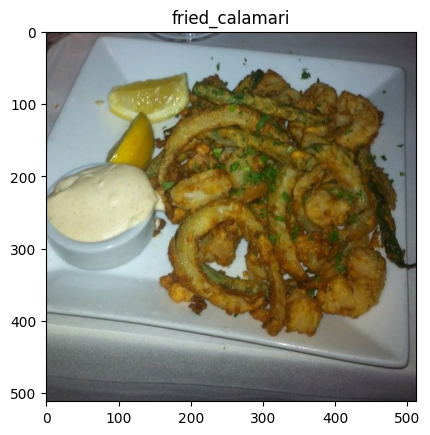

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
plt.imshow(image)
plt.title(class_names[label.numpy()])

# Create preprocessing functions for our data

Neural networks performs best when data is in a certain way ( e.g. batched, normalized etc).

However , not all data (including data from TensorFlow datasets) comes like this.

So in order to get it ready for a neural network , you will often have to write preprocessing functions and map it to your data

What we know about our data?

* In 'uint8' dtype
* Comprised of all different size tensors (different sized images) .
* Not scaled (the pixel values are between 0 and 255).

What we know models like:

* Data in 'float32' dtype (or mixed precision 'float16' and 'float32').
* For batches , TensorFlow likes all of the tensors within a batch to be of the same size.
* Scaled (values between 0 and 1 also called normalized tensors generally performed better) (We will use efficientnetb0 , it is already rescaled. But when we use something different model, we might rescale our pixel values.).

With these points in mind . we have got a few things we can tackle with a preprocessing functions.

This means our functions needs to:

1. Reshape our images to all the same size.
2. Convert the dtype of our images tensors from 'uint8' to 'float32'.

# Now our data is in tuple format (image , label). We will do some preprocessing steps with this information

In [12]:
# Make a function for preprocessing image

def preprocess_img(image , label , img_shape = 224):
  """
  Converts image dtype from 'uint8' -> 'float32' and reshapes
  our image to [img_shape , img_shape , color_channel]
  """

  image = tf.image.resize(image , [img_shape , img_shape])  # Reshape target image
  return tf.cast(image , tf.float32) , label  # Return the tuple of (float32_images , label)

In [13]:
# Preprocess a single sample image and check the outputs.

preprocessed_img = preprocess_img(image , label )[0]  # 0 dememizin sebebi tuple ın 0. indexini almak istememiz yani float32_images

print(f"Before preprocessing: \n  {image[ : 2]} \n Shape: {image.shape} \n Datatype : {image.dtype} ")
print(f"After preprocessing: \n {preprocessed_img[ : 2]} \n Shape : {preprocessed_img.shape} \n Datatype : {preprocessed_img.dtype}")

Before preprocessing: 
  [[[71 60 56]
  [70 59 55]
  [70 59 55]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]

 [[62 51 47]
  [64 53 49]
  [66 55 51]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]] 
 Shape: (512, 512, 3) 
 Datatype : <dtype: 'uint8'> 
After preprocessing: 
 [[[ 65.81122   54.811222  50.811222]
  [ 73.331635  62.331635  58.331635]
  [104.015305  89.80102   86.80102 ]
  ...
  [ 61.85712   59.071384  65.64286 ]
  [ 65.        60.        67.      ]
  [ 64.64282   59.642822  66.64282 ]]

 [[ 67.28571   56.285717  52.285717]
  [ 66.47449   55.47449   51.47449 ]
  [ 67.73979   53.525505  50.525505]
  ...
  [ 64.14284   61.3571    67.92857 ]
  [ 65.93368   60.933674  67.93368 ]
  [ 64.285645  59.285645  66.285645]]] 
 Shape : (224, 224, 3) 
 Datatype : <dtype: 'float32'>


# Batch and prepare datasets

We are now going to make our data input pipeline run really fast.



In [14]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func = preprocess_img , num_parallel_calls = tf.data.AUTOTUNE)  #AUTOTUNE uygulamamızın sebebi kullanabildiğin bütün gücü kullan diyoruz train ederken yani aslında really fast kısmı parallelize etme kısmında gerçekleşiyor. Bu çok önemli.
#  map işlemi, her veri örneği üzerinde belirli bir işlevi (map_func) uygulamak için kullanılır. Bu durumda, preprocess_img adlı işlev her veri örneği üzerinde uygulanacaktır. num_parallel_calls parametresi, işlevin kaç eşzamanlı iş parçacığında çalıştırılacağını belirtir. tf.data.AUTOTUNE, TensorFlow'un otomatik olarak en iyi iş parçacığı sayısını seçmesini sağlar.

In [15]:
# Shuffle train_data and turn it into batches and prefecth it (load it faster)

train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# İdeal value buffer_size için aslında len(train_data). Yani bu her birim zamanda kaç image ın shuffle edileceğini söylüyor. Eğer yeterli yer varsa memoryde len(train_data) kullanmak daha iyi
# Aslında pipeline görmüştüm microprocessorlerde onun gibi art arda yazıyoruz kodları direkt önce shuffle sonra batchlere bölme sonrasında da prefetch.

In [16]:
# Map preprocessing function to test data

test_data = test_data.map(map_func = preprocess_img , num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Prefetch aslında bizim bir sonraki batchimizi bir önceki batch bitmeden hazırlıyor yani daha hızlı process sağlıyor.
# En sona .cache() de ekleyebiliriz. Tekrardan preprocess etmeden ram i kullanıyor bu yüzden daha hızlı oluyor işlemler ama ram inde yer varsa mantıklı.
# test_data mızı shuffle etmemize gerek yok.

In [17]:
train_data , test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> Hey Tensorflow , map this preprocessing function (preprocess_img) accross our training dataset , then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch

> Prefetch işlemi CPU da oluyor. Yani biz GPU da pattern bulurken CPU da yeni batchimiz hazırlanıyor. Eğer ki biz prefetch uygulamasaydık ,  bizim batchlerimiz önce CPU da hazırlanıp sonrasında GPU ya geçecekti ve GPU da pattern bulurken yeni batch hazırlanmayacaktı yani sırayla olacaktı prefetch te GPU da pattern bulunurken batchler CPU da hazırlanmaya devam ediyor bu yüzden çok hızlı process oluyor.

# Create modelling callbacks

We are going to create a couple of callbacks to help us while our model trains:
* Tensorboard callback to log training results ( so we can visualize them later if need be ).
* ModelCheckpoint callback to save our model's progress after feature extraction

In [18]:
# Create tensorboard callback from helper_functions.py

# Create modelcheckpoint callback
checkpoint_path = "model_checkpoint/cp.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path ,
    monitor = "val_acc" ,
    save_best_only = True ,
    save_weights_only = True ,
    verbose = 0
)
# Verbose u arttırdıkça verdiği info artıyor.

# Setup mixed precision training

Mixed precision utilizes a combination of float32 and float16 data types to speed up our model's performance

Mixed precision kullanacaksak outputa kesinlikle dtype = tf.float32 eklememiz gerekiyor çünkü outputta float32 şeklinde verilmesi gerekiyor dataların. dtype parametresini eklememiz için de activation layerı ayrı bir şekilde yazmamız gerekiyor.

In [19]:
# Turn on mixed precision training

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # Set global data policy to mixed precision

base_model = tf.keras.applications.EfficientNetB0(include_top =False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (224,224,3) , name = "input_layer")

x = base_model(inputs , training = False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(len(class_names))(x)

outputs = tf.keras.layers.Activation("softmax" , dtype = tf.float32 , name = "softmax_float32")(x)

model = tf.keras.Model(inputs , outputs)

model.compile(loss = ["sparse_categorical_crossentropy"] ,  # Labellarımız one hot encoded formatta olmadıgı icin sparse kullanıyoruz.
              optimizer = tf.keras.optimizers.Adam() ,
              metrics = ["accuracy"]

              )





16705208/16705208 [==============================] - 2s 0us/step


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

# Checking dtype layer policies (are we using mixed precision?)

In [22]:
for layer in model.layers:
  print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [24]:
# Check the dtype_policy attributes of our efficientnetb0 layers
for layer in base_model.layers:
  print(layer.name , layer.trainable , layer.dtype , layer.dtype_policy)


input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [25]:
# Fit the model
history = model.fit(train_data ,
                    epochs = 3 ,
                    steps_per_epoch = len(train_data) ,
                    validation_data = test_data ,
                    validation_steps = len(test_data) ,

                    )

Epoch 1/3
2368/2368 [==============================] - 256s 100ms/step - loss: 1.7156 - accuracy: 0.5817 - val_loss: 1.1357 - val_accuracy: 0.6978
Epoch 2/3
2368/2368 [==============================] - 237s 98ms/step - loss: 1.1983 - accuracy: 0.6891 - val_loss: 1.0388 - val_accuracy: 0.7198
Epoch 3/3
2368/2368 [==============================] - 263s 110ms/step - loss: 1.0541 - accuracy: 0.7237 - val_loss: 0.9967 - val_accuracy: 0.7291


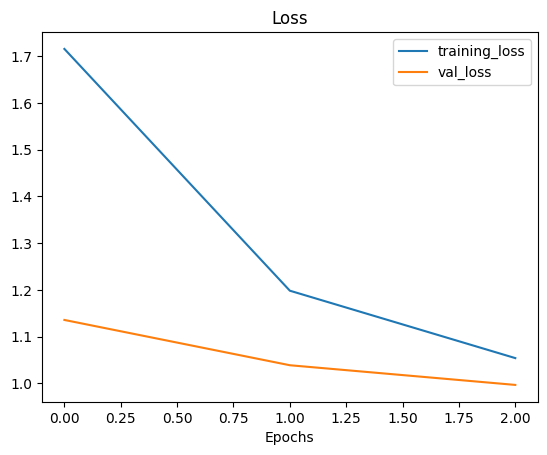

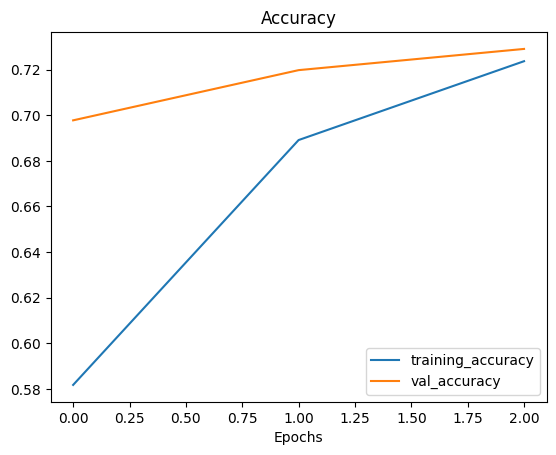

In [26]:
plot_loss_curves(history)